In [10]:
ENV["JULIA_PKG_SERVER"] = ""
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

using DataFrames
using Plots
using CategoricalArrays
using Random
using MLJBase: machine, transform
using TableTransforms
using Imbalance

  Activating project at `~/Documents/GitHub/Imbalance.jl/examples`


### 1. Generate Random Data

In [11]:
rng = Random.default_rng()

type="ColTable"
num_rows = 50
num_features = 5
class_probs = [0.5, 0.2, 0.3]
y_ind = 3

Xy, _ = generate_imbalanced_data(num_rows, num_features; class_probs, type, insert_y=y_ind, rng=42)
X, y = generate_imbalanced_data(num_rows, num_features; class_probs, type, rng=42)

((Column1 = [0.05234832229346974, -0.019860675183921164, 0.08206863998172909, 0.03138041684112896, 0.5089058235627838, 0.002459647663844919, 0.0019328913784266884, 0.8461979892918658, 0.40264191526050996, 0.030475428588115302  …  0.3957080212233609, 0.0141500881649179, 0.2970573477627664, -0.02460877316494258, 0.04025120345844229, 0.634705837727582, -0.00506418222490207, 0.03795031724487734, 0.4943810260069349, 0.05065395649735807], Column2 = [0.1716605660818352, 0.004796638940773451, 0.0784390820593219, 0.044367194145155116, 1.0599809566430862, -0.0029307699147034932, 0.17934949930113372, 1.8833950656833236, 1.7077435004315835, 0.20523750809044528  …  1.9558624079492894, 0.1984203254450218, 1.8414860795737433, 0.3015628061806917, 0.06952585645785958, 2.0932830117253336, 0.9455757839666663, 0.015272711595229138, 1.8629546425119403, 0.31743913893278813], Column3 = [0.4871234626031312, 0.6700045583211575, 0.6198869028599604, 0.5676093249492509, 0.23396099495089112, 0.685624315565238, 0.5

### 2. Apply Cluster Undersampler

#### Using Imbalance Only

In [12]:
X_under, y_under = cluster_undersample(
	X,
	y;
	mode = "nearest",
	ratios = Dict(0 => 1.0, 1 => 1.0, 2 => 0.9),
	rng = 42,
)

((Column1 = [0.0019328913784266884, -0.005334025161363873, 0.052246041772642346, 0.015520940651101794, -0.017806849763140932, 0.04025120345844229, -0.03578738883830446, 0.08247498601972209, 0.0412788402147565, 0.030475428588115302  …  0.4611009144309277, 0.8232665290270671, 0.6015388275997319, 0.9019684558733615, 0.3516276343998236, 0.3837922112754023, 0.831543715553752, 0.2970573477627664, 0.634705837727582, 0.8461979892918658], Column2 = [0.17934949930113372, -0.08088354938804873, 0.2962801534996991, 0.255998547544236, 0.15311167148776605, 0.06952585645785958, 0.04372091353770611, 0.3981767926313212, -0.04860523189393884, 0.20523750809044528  …  1.4363102193879556, 1.9256979472410745, 1.851105708250844, 1.948170566093281, 1.7518728968967887, 1.9462410034485642, 1.8105132127714865, 1.8414860795737433, 2.0932830117253336, 1.8833950656833236], Column3 = [0.5883119217720948, 0.8012966032152811, 0.4333694209608323, 0.7427788305541656, 0.5349635996681261, 0.5591211475049618, 0.674608609569

#### Using MLJ

In [13]:
naive_model = Imbalance.MLJ.ClusterUndersampler(
	mode = "nearest",
	ratios = Dict(0 => 1.0, 1 => 1.0, 2 => 0.9),
	maxiter = 50,
	rng = 42,
)
mach = machine(naive_model)
X_under, y_under = transform(mach, X, y)

((Column1 = [0.0019328913784266884, -0.005334025161363873, 0.052246041772642346, 0.015520940651101794, -0.017806849763140932, 0.04025120345844229, -0.03578738883830446, 0.08247498601972209, 0.0412788402147565, 0.030475428588115302  …  0.4611009144309277, 0.8232665290270671, 0.6015388275997319, 0.9019684558733615, 0.3516276343998236, 0.3837922112754023, 0.831543715553752, 0.2970573477627664, 0.634705837727582, 0.8461979892918658], Column2 = [0.17934949930113372, -0.08088354938804873, 0.2962801534996991, 0.255998547544236, 0.15311167148776605, 0.06952585645785958, 0.04372091353770611, 0.3981767926313212, -0.04860523189393884, 0.20523750809044528  …  1.4363102193879556, 1.9256979472410745, 1.851105708250844, 1.948170566093281, 1.7518728968967887, 1.9462410034485642, 1.8105132127714865, 1.8414860795737433, 2.0932830117253336, 1.8833950656833236], Column3 = [0.5883119217720948, 0.8012966032152811, 0.4333694209608323, 0.7427788305541656, 0.5349635996681261, 0.5591211475049618, 0.674608609569

#### Using TableTransforms

In [14]:
using Imbalance: TableTransforms.ClusterUndersampler
model_t = ClusterUndersampler(
	y_ind,
	mode = "nearest",
	ratios = Dict(0 => 1.0, 1 => 0.9, 2 => 1.0),
	maxiter = 50,
	rng = 42,
)
Xyover = Xy |> model_t

(Column1 = [0.06659593394243166, -0.07627338970571766, 0.046129655023959965, -0.06203998734842352, 0.014737998390011619, -0.00043931747713663385, 0.0004354287181994529, 0.021955672994772236, 0.06799066859509498, -0.024651481395648316  …  1.0123483693755257, 0.313653218570236, 0.12320022845706136, 0.406287397517314, 0.5837432844287728, 0.7575561434223407, 0.5426829052635868, 0.5074901865601431, 0.85038975361393, 0.3711516508850687],
 Column2 = [0.1922021500075654, -0.1731818341109505, 0.075494776310325, 0.07471185429903927, -0.09280547141135906, 0.21723792157238594, -0.21902861102698168, 0.06295920502417877, 0.23670239356640319, 0.1310316772501534  …  1.8089039050632285, 1.6209606034158313, 1.8725855341309459, 1.8570850139313118, 1.6839143543154869, 1.698634391321345, 1.398271837820609, 2.037411389908551, 1.5516338321935892, 1.4954827966744286],
 Column3 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0],
 Column4 = [0.9056282690828

### 3. Plot the Results

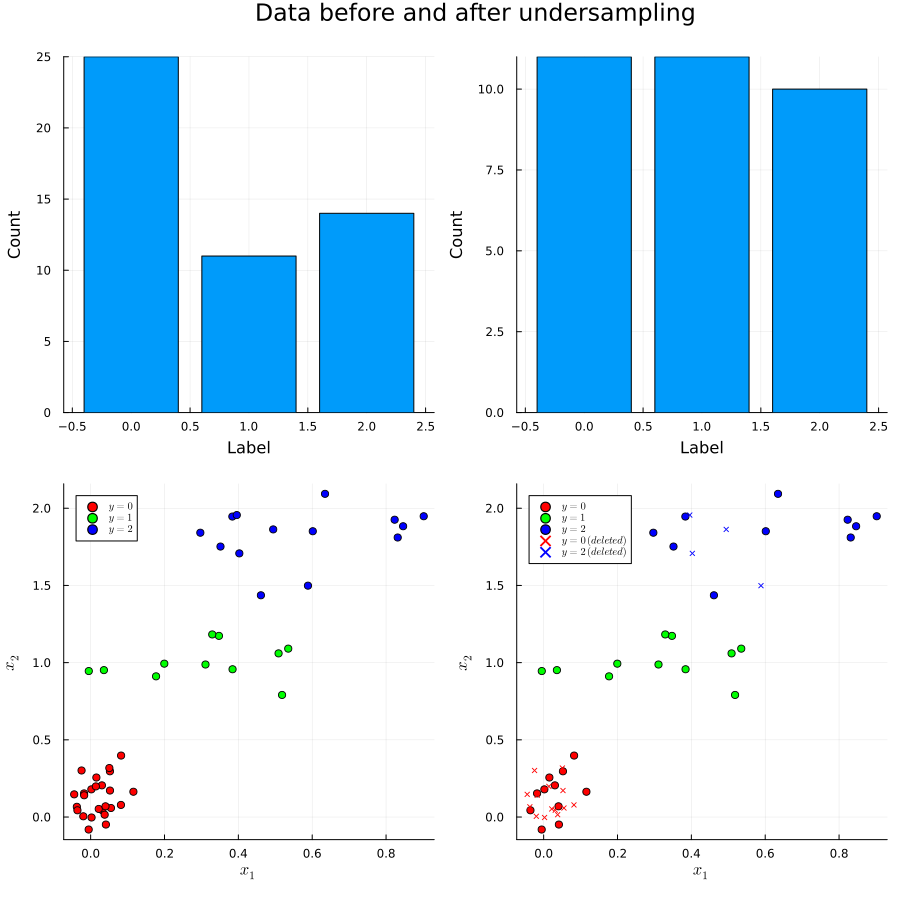

In [61]:
#include("plot.jl")                      # provides a plot function to compare results
plot_data(y, y_under, X, X_under)